In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from num2words import num2words
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter
import re
from textblob import TextBlob
from scipy.sparse import hstack
from google_trans_new import google_translator
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from xgboost import XGBClassifier

In [2]:
df1 = pd.read_csv("Constraint_Train.csv")
df2 = pd.read_csv("english_test_with_labels.csv")

In [3]:
df = pd.concat([df1, df2])

In [4]:
df = df[df['id'] != 4287]
df = df[df['id'] != 4698]
df = df.sample(frac=1).reset_index(drop=True)

# Preprocessing

In [5]:
def convert_lower_case(data):
    return np.char.lower(data)

In [6]:
def remove_urls_hashtag(data):
    words = word_tokenize(str(data))
    j = 0
    new_text = ""
    while(j<len(words)): 
        if 'http' in words[j] or 'www' in words[j]:
            j = j+3
        elif '#' in words[j]:
            j = j+2
        else:
            new_text = new_text + words[j] + " "
            j = j+1
    return new_text

In [7]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words:
            new_text = new_text + " " + w
    return new_text

In [8]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', ' ')
    data = np.char.replace(data, "'", "")
    data = np.char.replace(data, "'", "")
    return data

In [9]:
def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

In [10]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

In [11]:
def convert_contractions(data):
    APPO = {"ain't": "am not", "aren't" : "are not", "can't" : "cannot", "'cause": "because",
    "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not",
    "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would",
    "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'll" : "I will",
    "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", 
    "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not",
    "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is",
    "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would",
    "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are",
    "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are",
    "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would",
    "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have",
    "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will",
    "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not",
    "we'll":" will", "we're": "we are", "we've": "we have", "didn't": "did not", "tryin'":"trying"}
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w in APPO:
            new_text = new_text + " " + APPO[w]
        else:
            new_text = new_text + " " + w
    return new_text

In [12]:
def remove_single(data):
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if len(w) > 2:
            new_text = new_text + " " + w
    return new_text

In [13]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_urls_hashtag(data)
    data = convert_contractions(data)
    data = remove_single(data)
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    data = lemmatizing(data)
    data = remove_single(data)
    return data

In [14]:
def preprocess_senti(data):
    data = convert_lower_case(data)
    data = remove_urls_hashtag(data)
    data = convert_contractions(data)
    data = remove_single(data)
    data = remove_punctuation(data)
    data = lemmatizing(data)
    data = remove_single(data)
    return data

In [15]:
df_clean_senti = df.copy(deep=True)
df_clean = df.copy(deep=True)

In [16]:
preprocessed_txt_senti = []
preprocessed_txt = []
for i in df['tweet']:
    preprocessed_txt_senti.append(str(preprocess_senti(i)))
    preprocessed_txt.append(str(preprocess(i)))

In [17]:
df_clean_senti['tweet'] = preprocessed_txt_senti
df_clean['tweet'] = preprocessed_txt

In [18]:
df_clean_senti.to_csv('Preprocessed Dataset Sentiment.csv')
df_clean.to_csv('Preprocessed Dataset.csv')

In [19]:
df_clean_senti = pd.read_csv('Preprocessed Dataset Sentiment.csv').drop(['Unnamed: 0'],axis=1)
df_clean = pd.read_csv('Preprocessed Dataset.csv').drop(['Unnamed: 0'],axis=1)

In [20]:
# 4698, 4287
df_clean = df_clean.dropna().reset_index(drop=True)
df_clean_senti = df_clean_senti.dropna().reset_index(drop=True)

# Exploratory Data Analysis (EDA)

In [21]:
df_real = df_clean[df_clean['label'] == 'real']

In [22]:
df_fake = df_clean[df_clean['label'] == 'fake']

In [23]:
print('Number of real labels ',len(df_real))
print('Number of fake labels ',len(df_fake))

Number of real labels  4480
Number of fake labels  4078


## Top 10 Unigrams (Real News)

In [24]:
unigram_text = []
for i in df_real['tweet']:
    unigram_text += word_tokenize(i)

In [25]:
unigram_count = Counter(unigram_text).most_common()[:10]

In [26]:
unigrams = {i[0]:i[1] for i in unigram_count}

### Plot

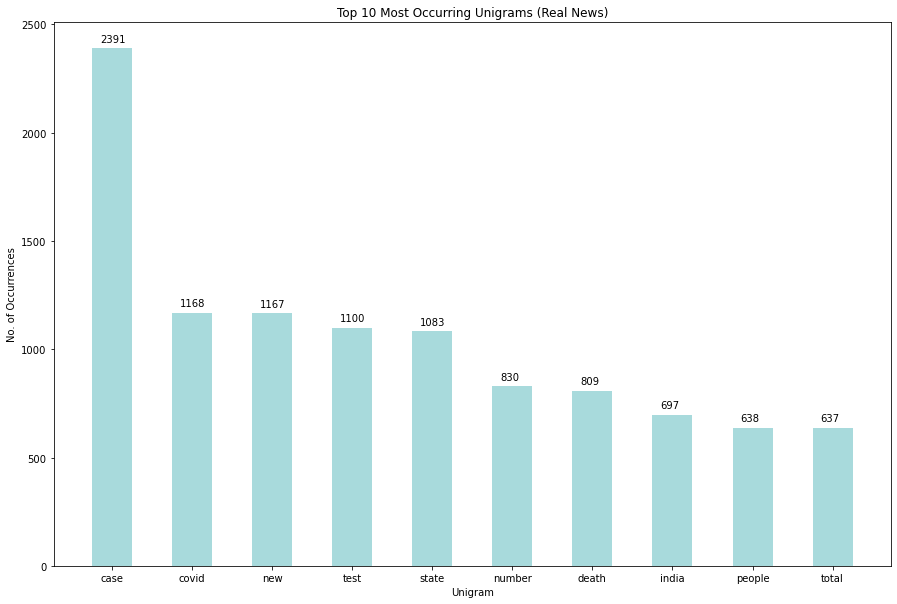

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(unigrams.keys(), unigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(unigrams.values()):
    ax.text(i-0.15, v+30, str(round(v,2)))
plt.title('Top 10 Most Occurring Unigrams (Real News)')
plt.xlabel('Unigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Bigrams (Real News)

In [28]:
bigram_text = []
for i in df_real['tweet']:
    bigram_text.append(i)

In [29]:
bigram_tokens = []
for i in bigram_text:
    tokens = word_tokenize(i)
    for j, x in enumerate(tokens):
        if j < len(i.split()) - 1:
            bigram_tokens.append(x + " " + tokens[j+1])

In [30]:
bigram_count = Counter(bigram_tokens).most_common()[:10]

In [31]:
bigrams = {i[0]:i[1] for i in bigram_count}

### Plot

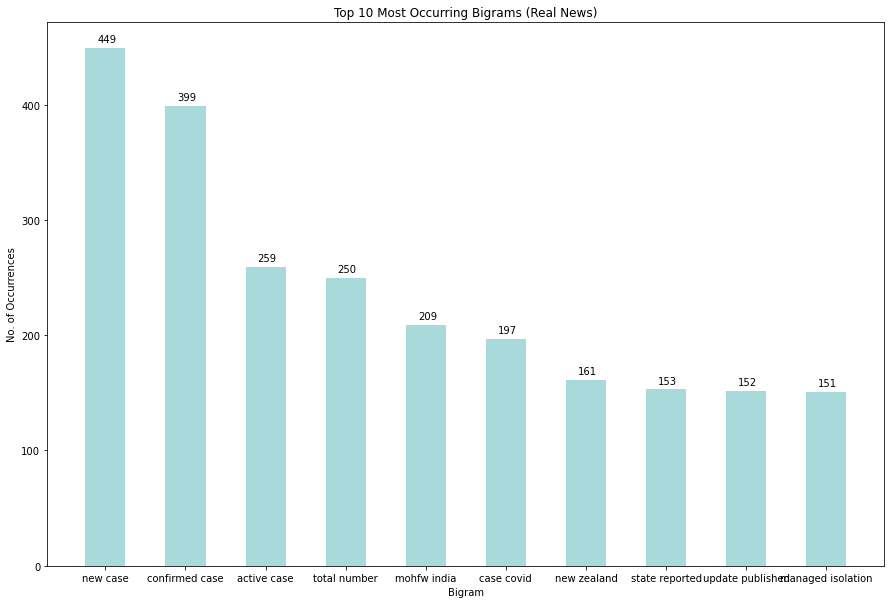

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(bigrams.keys(), bigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(bigrams.values()):
    ax.text(i-0.1, v+5, str(round(v,2)))
plt.title('Top 10 Most Occurring Bigrams (Real News)')
plt.xlabel('Bigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Unigrams (Fake News)

In [33]:
unigram_text = []
for i in df_fake['tweet']:
    unigram_text += word_tokenize(i)

In [34]:
unigram_count = Counter(unigram_text).most_common()[:10]

In [35]:
unigrams = {i[0]:i[1] for i in unigram_count}

### Plot

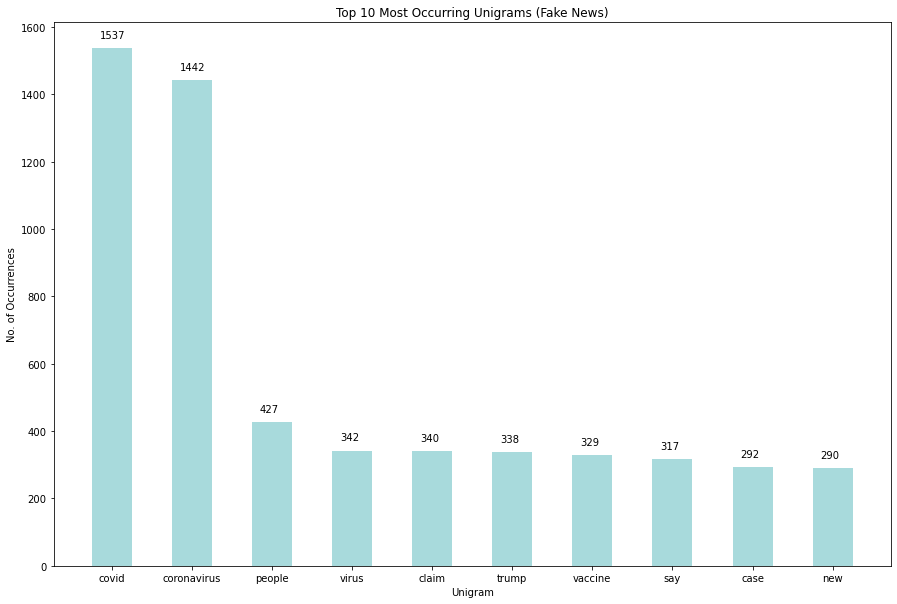

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(unigrams.keys(), unigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(unigrams.values()):
    ax.text(i-0.15, v+30, str(round(v,2)))
plt.title('Top 10 Most Occurring Unigrams (Fake News)')
plt.xlabel('Unigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Top 10 Bigrams (Fake News)

In [37]:
bigram_text = []
for i in df_fake['tweet']:
    bigram_text.append(i)

In [38]:
bigram_tokens = []
for i in bigram_text:
    tokens = word_tokenize(i)
    for j, x in enumerate(tokens):
        if j < len(i.split()) - 1:
            bigram_tokens.append(x + " " + tokens[j+1])

In [39]:
bigram_count = Counter(bigram_tokens).most_common()[:10]

In [40]:
bigrams = {i[0]:i[1] for i in bigram_count}

### Plot

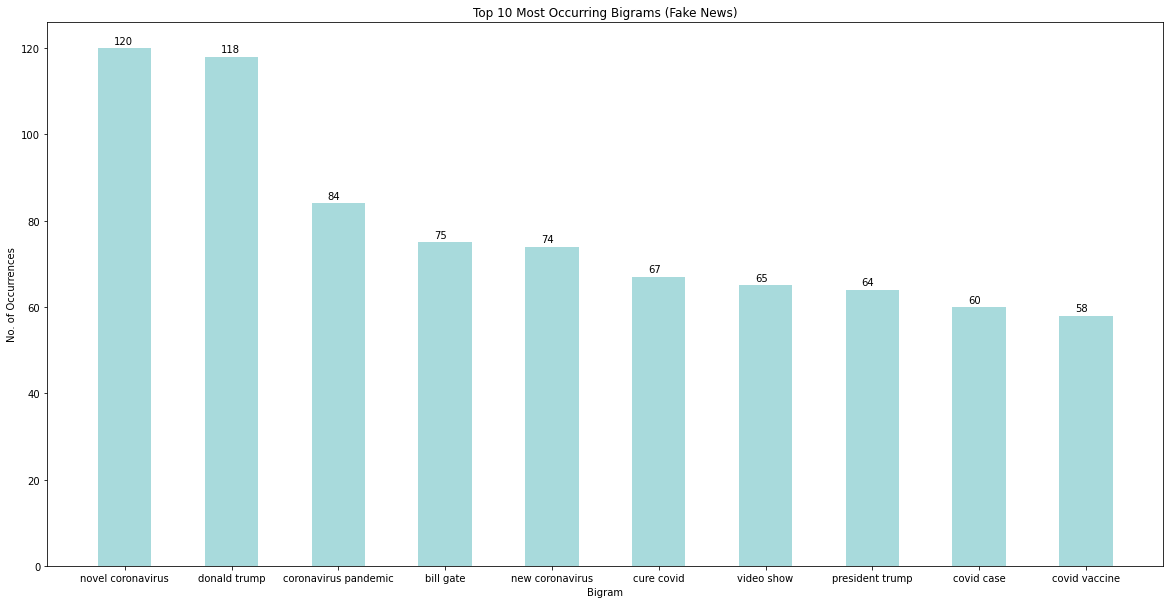

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(bigrams.keys(), bigrams.values(), color='#a8dadc', width=0.5)
for i, v in enumerate(bigrams.values()):
    ax.text(i-0.1, v+1, str(round(v,2)))
plt.title('Top 10 Most Occurring Bigrams (Fake News)')
plt.xlabel('Bigram')
plt.ylabel('No. of Occurrences')
plt.show()

## Word Cloud of Real News

In [42]:
real_text = ""
for i in df_real['tweet']:
    real_text += i + " "

In [43]:
stop_words = set(STOPWORDS)

In [44]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(real_text)

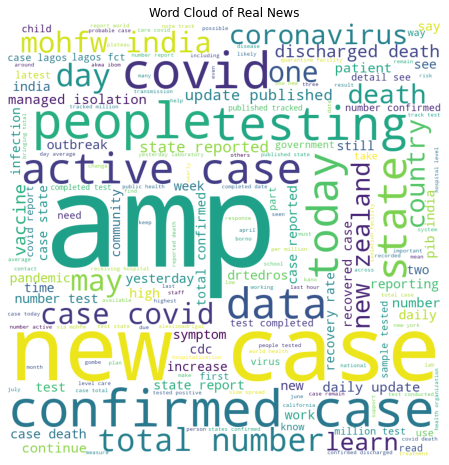

In [45]:
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.title('Word Cloud of Real News')
plt.axis("off")
plt.show()

## Word Cloud of Fake News

In [46]:
fake_text = ""
for i in df_fake['tweet']:
    fake_text += i + " "

In [47]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(fake_text)

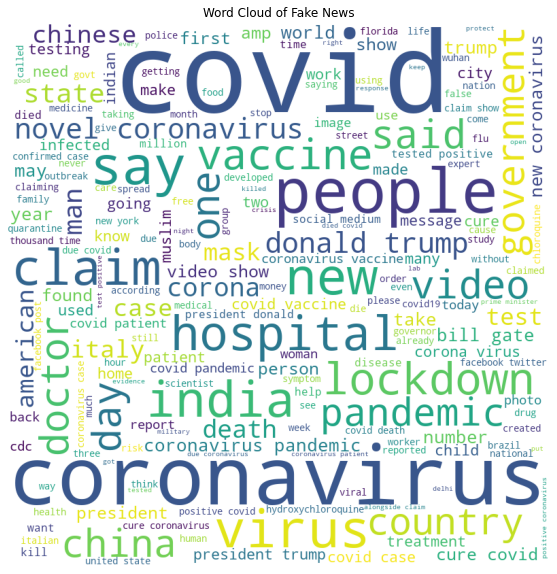

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title('Word Cloud of Fake News')
plt.axis("off")
plt.show()

# Feature Extraction
We've broadly classified our feature engineering ideas in the following two groups:

## Direct Features:
Following techniques will be used under Direct Features:  
1. Bag of Words (Unigram, Bigram, Trigrams)  
    a. Count Vectorizer  
    b. TF-IDF Vectorizer
2. Word Embeddings (Example: GloVe)  

## Indirect Features:
Following features will be used under Indirect Features:  
1. Count of Words (Length of a Tweet)  
2. Count of Unique Words  
3. Count of Letters  
4. Count of Stop Words  
5. Polarity Score  
6. Subjectivity Score

## Indirect Features

In [49]:
# Word Count
df['count_words'] = df['tweet'].apply(lambda x: len(str(x).split()))
MinMax1 = MinMaxScaler()
df['count_words'] = MinMax1.fit_transform(np.array(df['count_words']).reshape(-1,1))

In [50]:
# Unique Word Count
df['count_unique_words'] = df['tweet'].apply(lambda x: len(set(str(x).split())))
MinMax2 = MinMaxScaler()
df['count_unique_words'] = MinMax2.fit_transform(np.array(df['count_unique_words']).reshape(-1,1))

In [51]:
# Letter Count
df['count_letters'] = df['tweet'].apply(lambda x: len(str(x)))
MinMax3 = MinMaxScaler()
df['count_letters'] = MinMax3.fit_transform(np.array(df['count_letters']).reshape(-1,1))

In [52]:
# Number of Stopwords
df['count_stopwords'] = df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
MinMax4 = MinMaxScaler()
df['count_stopwords'] = MinMax4.fit_transform(np.array(df['count_stopwords']).reshape(-1,1))

In [53]:
# Number of Hashtags
df['count_hashtags'] = df['tweet'].apply(lambda x: len(re.findall(r'#([a-z0-9]+)', str(x))))
MinMax5 = MinMaxScaler()
df['count_hashtags'] = MinMax5.fit_transform(np.array(df['count_hashtags']).reshape(-1,1))

In [54]:
# Polarity Score
df['polarity'] = [TextBlob(df['tweet'][i]).sentiment.polarity for i in range(len(df))]

In [55]:
# Subjectivity Score
df['subjectivity'] = [TextBlob(df['tweet'][i]).sentiment.subjectivity for i in range(len(df))]

In [56]:
df_real_tweet = df[df['label'] == 'real']
df_fake_tweet = df[df['label'] == 'fake']

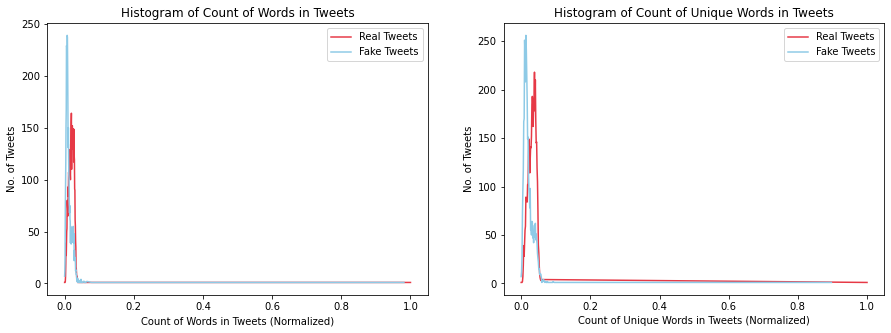

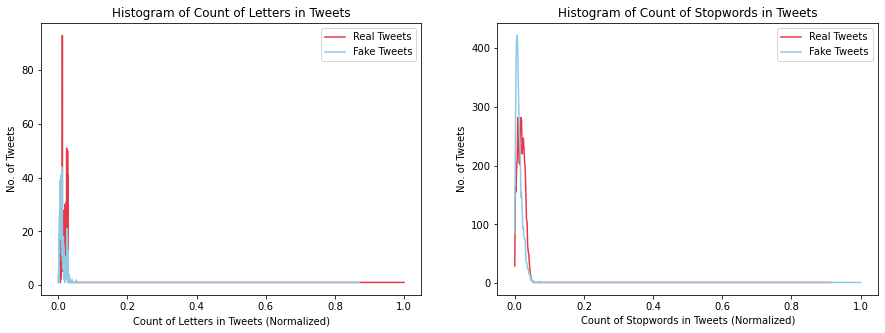

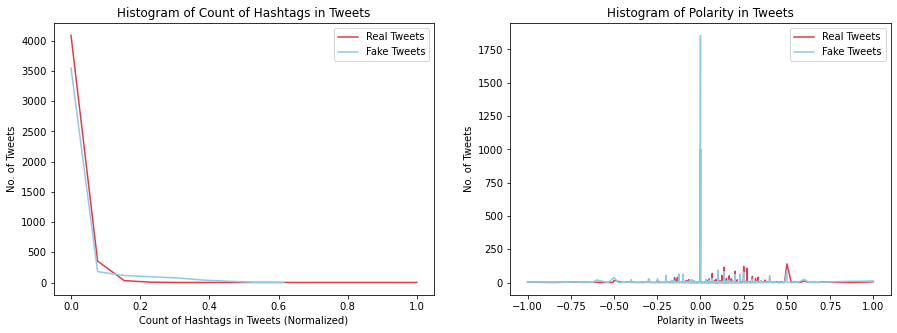

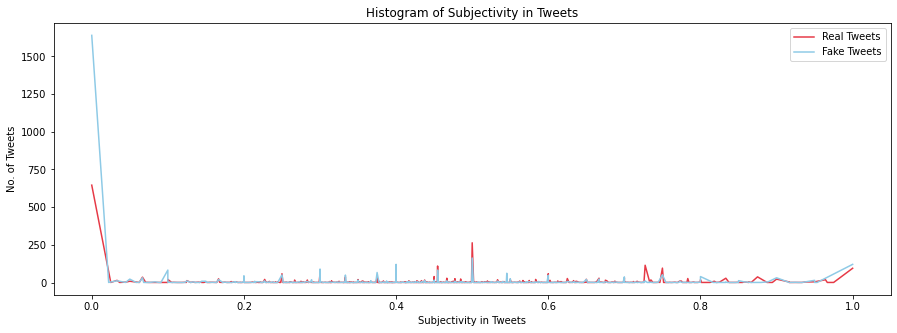

In [57]:
f = plt.figure(figsize=(15,5))
real_counter_word_count = Counter(df_real_tweet['count_words'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['count_words'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f.add_subplot(1,2,1)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Count of Words in Tweets (Normalized)')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Count of Words in Tweets')

real_counter_word_count = Counter(df_real_tweet['count_unique_words'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['count_unique_words'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f.add_subplot(1,2,2)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Count of Unique Words in Tweets (Normalized)')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Count of Unique Words in Tweets')

f1 = plt.figure(figsize=(15,5))
real_counter_word_count = Counter(df_real_tweet['count_letters'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['count_letters'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f1.add_subplot(1,2,1)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Count of Letters in Tweets (Normalized)')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Count of Letters in Tweets')

real_counter_word_count = Counter(df_real_tweet['count_stopwords'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['count_stopwords'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f1.add_subplot(1,2,2)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Count of Stopwords in Tweets (Normalized)')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Count of Stopwords in Tweets')

f2 = plt.figure(figsize=(15,5))
real_counter_word_count = Counter(df_real_tweet['count_hashtags'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['count_hashtags'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f2.add_subplot(1,2,1)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Count of Hashtags in Tweets (Normalized)')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Count of Hashtags in Tweets')

real_counter_word_count = Counter(df_real_tweet['polarity'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['polarity'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f2.add_subplot(1,2,2)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Polarity in Tweets')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Polarity in Tweets')

f3 = plt.figure(figsize=(15,5))
real_counter_word_count = Counter(df_real_tweet['subjectivity'])
real_counter_word_count = sorted(real_counter_word_count.items())
real_dict = {i[0]:i[1] for i in real_counter_word_count}
fake_counter_word_count = Counter(df_fake_tweet['subjectivity'])
fake_counter_word_count = sorted(fake_counter_word_count.items())
fake_dict = {i[0]:i[1] for i in fake_counter_word_count}
f3.add_subplot(1,1,1)
plt.plot(real_dict.keys(), real_dict.values(), color='#e63946', label='Real Tweets')
plt.plot(fake_dict.keys(), fake_dict.values(), color='#8ecae6', label='Fake Tweets')
plt.xlabel('Subjectivity in Tweets')
plt.ylabel('No. of Tweets')
plt.legend()
plt.title('Histogram of Subjectivity in Tweets')

plt.show()

## Direct Features

In [58]:
unitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(1, 1), max_features=1000)
bitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(2, 2), max_features=1000)
# unitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(1, 1), min_df=2)
# bitfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, ngram_range=(2, 2), min_df=2)

In [59]:
tfidf_feat1 = unitfidf_vectorizer.fit_transform(df_clean['tweet'])
tfidf_feat2 = bitfidf_vectorizer.fit_transform(df_clean['tweet'])

In [60]:
tfidf_feat11 = tfidf_feat1.toarray()
tfidf_feat22 = tfidf_feat2.toarray()

In [61]:
count_cols = ['count_words','count_unique_words','count_letters','count_stopwords','count_hashtags','polarity','subjectivity']

In [62]:
a1 = np.concatenate((tfidf_feat11,tfidf_feat22),axis=1)

In [63]:
train_features = np.concatenate((a1,df[count_cols]),axis=1)

In [64]:
np.shape(train_features)

(8558, 2007)

In [65]:
labels = df_clean['label']

# Oversampling

In [66]:
oversample = SMOTE()
X, y = oversample.fit_resample(train_features, labels)

In [67]:
count_real = 0
count_fake = 0
for x in y:
    if x == 'real':
        count_real+=1
    else:
        count_fake+=1

In [68]:
count_real

4480

In [69]:
count_fake

4480

In [70]:
df[count_cols]

,count_words,count_unique_words,count_letters,count_stopwords,count_hashtags,polarity,subjectivity
0,0.006752,0.012422,0.005516,0.008865,0.0,0.000000,0.000000
1,0.017556,0.031056,0.025217,0.001773,0.0,0.000000,0.000000
2,0.024983,0.045963,0.024133,0.024823,0.0,0.176768,0.440909
3,0.016880,0.027329,0.014578,0.023050,0.0,0.001515,0.527273
4,0.004727,0.008696,0.006994,0.001773,0.0,0.400000,0.900000
...,...,...,...,...,...,...,...
8553,0.008778,0.014907,0.011229,0.007092,0.0,0.000000,0.000000
8554,0.023633,0.036025,0.026103,0.026596,0.0,0.339394,0.509091
8555,0.029034,0.044720,0.025611,0.031915,0.0,0.150000,1.000000
8556,0.011479,0.021118,0.012017,0.012411,0.0,0.400000,0.400000


# Training Models

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [72]:
X_train.shape

(6272, 2007)

## Logistic Regeression

In [73]:
model1 = LogisticRegression()
model1.fit(X_train,y_train)

LogisticRegression()

In [74]:
len(model1.coef_[0])

2007

In [75]:
print('Beta of subjectivity',model1.coef_[0][2006])
print('Beta of polarity',model1.coef_[0][2005])
print('Beta of hashtags',model1.coef_[0][2004])
print('Beta of stopwords',model1.coef_[0][2003])
print('Beta of letters',model1.coef_[0][2002])
print('Beta of unique words',model1.coef_[0][2001])
print('Beta of words',model1.coef_[0][2000])

Beta of subjectivity 0.7241564261375755
Beta of polarity 0.6661927244149171
Beta of hashtags -4.096667425747811
Beta of stopwords 0.8947680012068104
Beta of letters 1.4378534602009718
Beta of unique words 1.61364451659553
Beta of words 1.0074555202439708


In [76]:
X_train[:,2006]

array([0.375     , 0.5       , 0.96428571, ..., 0.        , 0.85      ,
       0.55      ])

In [77]:
y_train

1714    fake
6811    real
4701    real
339     fake
3480    real
        ... 
5734    real
5191    real
5390    fake
860     fake
7270    fake
Name: label, Length: 6272, dtype: object

In [78]:
a_train = y_train
a_train1 = []
for x in a_train:
    if x == 'real':
        a_train1.append(1)
    else:
        a_train1.append(0)

In [79]:
print('Correlation of subjectivity',np.correlate(X_train[:,2006],a_train1))
print('Correlation of polarity',np.correlate(X_train[:,2005],a_train1))
print('Correlation of hashtags',np.correlate(X_train[:,2004],a_train1))
print('Correlation of stopwords',np.correlate(X_train[:,2003],a_train1))
print('Correlation of letters',np.correlate(X_train[:,2002],a_train1))
print('Correlation of unique words',np.correlate(X_train[:,2001],a_train1))
print('Correlation of words',np.correlate(X_train[:,2000],a_train1))

Correlation of subjectivity [1330.51118996]
Correlation of polarity [310.68007774]
Correlation of hashtags [25.15384615]
Correlation of stopwords [60.78191489]
Correlation of letters [62.29186367]
Correlation of unique words [100.71055901]
Correlation of words [62.00877785]


1 - Real 0 - Fake 
So, this shows that real news tend to have more subjectivity and more polarity whereas fake newstend to have more number of hashtatgs and more stopwords 

In [80]:
#https://arxiv.org/pdf/2005.05710.pdf - - Reminder - Very good paper

In [81]:
a = y_test
a1 = []
for x in a:
    if x == 'real':
        a1.append(1)
    else:
        a1.append(0)

In [82]:
def convert_label_to_int(predictions):
    a2 = []
    for x in predictions:
        if x == 'real':
            a2.append(1)
        else:
            a2.append(0)
    return a2

In [83]:
predictions_train = model1.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9502551020408163


In [84]:
predictions1 = model1.predict(X_test)
predictions1 = convert_label_to_int(predictions1)

In [85]:
print("Accuracy of Logistic Regression: ",accuracy_score(a1,predictions1))
print("Precision of Logistic Regression: ",precision_score(a1,predictions1))
print("Recall of Logistic Regression: ",recall_score(a1,predictions1))
print("F1_score of Logistic Regression: ",f1_score(a1,predictions1))

Accuracy of Logistic Regression:  0.9136904761904762
Precision of Logistic Regression:  0.9226686884003032
Recall of Logistic Regression:  0.9034892353377877
F1_score of Logistic Regression:  0.9129782445611403


## Random Forest

In [86]:
model2 = RandomForestClassifier()
model2.fit(X_train,y_train)

RandomForestClassifier()

In [87]:
predictions_train = model2.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  1.0


In [88]:
predictions2 = model2.predict(X_test)
predictions2 = convert_label_to_int(predictions2)

In [89]:
print("Accuracy of Random Forest Classifier: ",accuracy_score(a1,predictions2))
print("Precision of Random Forest Classifier: ",precision_score(a1,predictions2))
print("Recall of Random Forest Classifier: ",recall_score(a1,predictions2))
print("F1_score of Random Forest Classifier: ",f1_score(a1,predictions2))

Accuracy of Random Forest Classifier:  0.8969494047619048
Precision of Random Forest Classifier:  0.918622848200313
Recall of Random Forest Classifier:  0.8715664439495174
F1_score of Random Forest Classifier:  0.8944761904761905


## Naive Bayes

In [90]:
model3 = GaussianNB()
model3.fit(X_train,y_train)

GaussianNB()

In [91]:
predictions_train = model3.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.8647959183673469


In [92]:
predictions3 = model3.predict(X_test)
predictions3 = convert_label_to_int(predictions3)

In [93]:
print("Accuracy of Naive Bayes: ",accuracy_score(a1,predictions3))
print("Precision of Naive Bayes: ",precision_score(a1,predictions3))
print("Recall of Naive Bayes: ",recall_score(a1,predictions3))
print("F1_score of Naive Bayes: ",f1_score(a1,predictions3))

Accuracy of Naive Bayes:  0.8426339285714286
Precision of Naive Bayes:  0.9529411764705882
Recall of Naive Bayes:  0.7216035634743875
F1_score of Naive Bayes:  0.8212927756653993


## SVM Classifier

In [94]:
model4 = svm.SVC()
model4.fit(X_train,y_train)

SVC()

In [95]:
predictions_train = model4.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9803890306122449


In [96]:
predictions4 = model4.predict(X_test)
predictions4 = convert_label_to_int(predictions4)

In [97]:
print("Accuracy of SVM: ",accuracy_score(a1,predictions4))
print("Precision of SVM: ",precision_score(a1,predictions4))
print("Recall of SVM: ",recall_score(a1,predictions4))
print("F1_score of SVM: ",f1_score(a1,predictions4))

Accuracy of SVM:  0.9159226190476191
Precision of SVM:  0.9301611665387567
Recall of SVM:  0.8997772828507795
F1_score of SVM:  0.9147169811320756


## Stochastic Gradient Descent

In [98]:
model5 = SGDClassifier(loss = "perceptron",penalty = "elasticnet")
model5.fit(X_train,y_train)

SGDClassifier(loss='perceptron', penalty='elasticnet')

In [99]:
predictions_train = model5.predict(X_train)
print("Training accuracy: ",accuracy_score(predictions_train,y_train))

Training accuracy:  0.9440369897959183


In [100]:
predictions5 = model5.predict(X_test)
predictions5 = convert_label_to_int(predictions5)

In [101]:
print("Accuracy of SGD With Elastic loss: ",accuracy_score(a1,predictions5))
print("Precision of SGD With Elastic loss: ",precision_score(a1,predictions5))
print("Recall of SGD With Elastic loss: ",recall_score(a1,predictions5))
print("F1_score of SGD With Elatic loss: ",f1_score(a1,predictions5))

Accuracy of SGD With Elastic loss:  0.8850446428571429
Precision of SGD With Elastic loss:  0.8483221476510067
Recall of SGD With Elastic loss:  0.9383815887156645
F1_score of SGD With Elatic loss:  0.8910821290095171


## XGBoost

In [102]:
model6 = XGBClassifier(objective='binary:logistic')
model6.fit(X_train,y_train)

/Users/sanketkhajuria/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:14:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
predictions6 = model6.predict(X_test)
predictions6 = convert_label_to_int(predictions6)

In [104]:
print("Accuracy of XGBosst: ",accuracy_score(a1,predictions6))
print("Precision of XGBoost: ",precision_score(a1,predictions6))
print("Recall of XGBoost: ",recall_score(a1,predictions6))
print("F1_score of XGBoost: ",f1_score(a1,predictions6))

Accuracy of XGBosst:  0.9118303571428571
Precision of XGBoost:  0.9147982062780269
Recall of XGBoost:  0.9086859688195991
F1_score of XGBoost:  0.911731843575419


## ROC Curve

Area under ROC of Logistic Regression:  0.9137132977583793
Area under ROC of Random Forest:  0.897006189909136
Area under ROC of Naive Bayes:  0.8429046900145988
Area under ROC of SVM:  0.9159587383679699
Area under ROC of SGD:  0.8849253208306137
Area under ROC of XGB:  0.9118373915686363


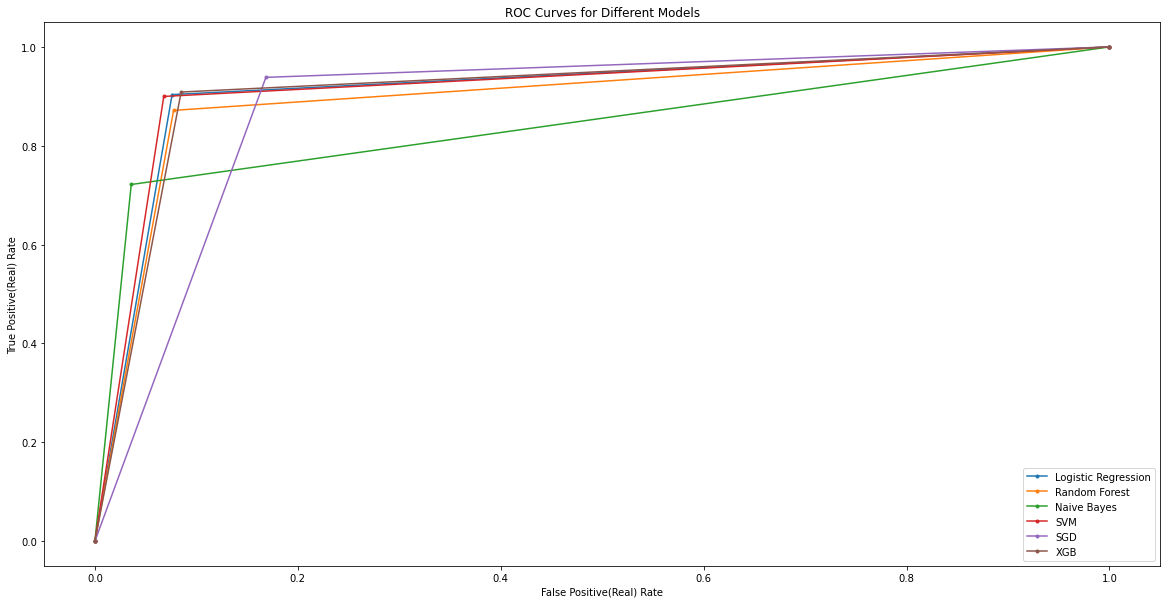

In [105]:
fpr1, tpr1 , _ = roc_curve(a1,predictions1)
fpr2, tpr2 , _ = roc_curve(a1,predictions2)
fpr3, tpr3 , _ = roc_curve(a1,predictions3)
fpr4, tpr4 , _ = roc_curve(a1,predictions4)
fpr5, tpr5 , _ = roc_curve(a1,predictions5)
fpr6, tpr6 , _ = roc_curve(a1,predictions6)

plt.figure(figsize=(20,10))

plt.plot(fpr1,tpr1,marker = '.',label = 'Logistic Regression')
plt.plot(fpr2,tpr2,marker = '.',label = 'Random Forest')
plt.plot(fpr3,tpr3,marker = '.',label = 'Naive Bayes')
plt.plot(fpr4,tpr4,marker = '.',label = 'SVM')
plt.plot(fpr5,tpr5,marker = '.',label = 'SGD')
plt.plot(fpr6,tpr6,marker = '.',label = 'XGB')

plt.xlabel('False Positive(Real) Rate')
plt.ylabel('True Positive(Real) Rate')
plt.title('ROC Curves for Different Models')
plt.legend()

print('Area under ROC of Logistic Regression: ',roc_auc_score(a1,predictions1))
print('Area under ROC of Random Forest: ',roc_auc_score(a1,predictions2))
print('Area under ROC of Naive Bayes: ',roc_auc_score(a1,predictions3))
print('Area under ROC of SVM: ',roc_auc_score(a1,predictions4))
print('Area under ROC of SGD: ',roc_auc_score(a1,predictions5))
print('Area under ROC of XGB: ',roc_auc_score(a1,predictions6))

XGB and Logistic Regression performed the best whereas Naive Bayes performed the worst 

# Source credibility

In [106]:
!pip install tweepy

In [107]:
import tweepy
from keys import *

In [108]:
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_secret = '*************************'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [109]:
def feature_transform(array_texts):
    
    df1 = pd.DataFrame(array_texts,columns = ['tweet'])
    feat1 = unitfidf_vectorizer.transform(array_texts).toarray()
    feat2 = bitfidf_vectorizer.transform(array_texts).toarray()
        
    count_cols = ['count_words','count_unique_words','count_letters','count_stopwords','count_hashtags','polarity','subjectivity']
    
    df1['count_words'] = df1['tweet'].apply(lambda x: len(str(x).split()))    
    df1['count_words'] = MinMax1.transform(np.array(df1['count_words']).reshape(-1,1))
        
    df1['count_unique_words'] = df1['tweet'].apply(lambda x: len(set(str(x).split())))
    df1['count_unique_words'] = MinMax2.transform(np.array(df1['count_unique_words']).reshape(-1,1))
        
    df1['count_letters'] = df1['tweet'].apply(lambda x: len(str(x)))
    df1['count_letters'] = MinMax3.transform(np.array(df1['count_letters']).reshape(-1,1))
        
    df1['count_stopwords'] = df1['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
    df1['count_stopwords'] = MinMax4.transform(np.array(df1['count_stopwords']).reshape(-1,1))
        
    df1['count_hashtags'] = df1['tweet'].apply(lambda x: len(re.findall(r'#([a-z0-9]+)', str(x))))
    df1['count_hashtags'] = MinMax5.transform(np.array(df1['count_hashtags']).reshape(-1,1))
        
    df1['polarity'] = [TextBlob(df1['tweet'][i]).sentiment.polarity for i in range(len(df1))]
    df1['subjectivity'] = [TextBlob(df1['tweet'][i]).sentiment.subjectivity for i in range(len(df1))]
        
    a1 = np.concatenate((feat1,feat2),axis=1)
    train_features1 = np.concatenate((a1,df1[count_cols]),axis=1)
    
    return train_features1


In [113]:
dict_source = {}

In [114]:
def source_credible(username):
    
    if username in dict_source:
        return dict_source[username]
    else:
        tweets = api.user_timeline(screen_name=username,exclude_replies = True, include_rts = True)
        #,lang = 'en',tweet_mode = 'extended'
        array_texts_original = []
        array_texts = []
        
        for tweet in tweets:
            tweet = tweet._json
            #print(type(tweet['text']))
            #print()
            array_texts_original.append(tweet['text'])
            translator = google_translator()
            if(tweet['lang'] == 'hi'):
                pass
#                 r = translator.translate(tweet['text'], lang_src='hi', lang_tgt='en')
#                 array_texts.append(preprocess(r))
            else:
                array_texts.append(preprocess(tweet['text']))
            
        
        
        train_features1 = feature_transform(array_texts)

        prediction_model = model1.predict(train_features1)
        
        count_fake = 0
        
        for x in prediction_model:
            if x == 'fake':
                count_fake+=1
        
        credibility_fake = (count_fake)/len(prediction_model) 
        
        dict_source[username] = 1 - credibility_fake
        
        return array_texts_original,prediction_model,1-credibility_fake

In [115]:
tweets,predictions,credibility = source_credible('COVIDIOTS')
print('Source credibility is: ',credibility)

Source credibility is:  0.11111111111111116


In [116]:
print(len(tweets))

18


In [117]:
print(tweets[0])
print('predicted label: ',predictions[0])

RT @JoeBiden: I can’t believe I have to say this, but please don’t drink bleach.
predicted label:  fake


In [118]:
tweets,predictions,credibility = source_credible('CovidVaccineLA')
print('Source credibility is: ',credibility)

Source credibility is:  1.0


In [119]:
tweets,predictions,credibility = source_credible('COVIDNewsByMIB')
print('Source credibility is: ',credibility)

Source credibility is:  0.25


In [120]:
print(tweets[0])
print('predicted label: ',predictions[0])

RT @PMOIndia: देश बड़े लक्ष्य तय करना और उन्हें हासिल करना जानता है।

लेकिन, इसके लिए हमें सतत सावधान रहने की जरूरत है।

हमें लापरवाह नहीं…
predicted label:  fake


In [121]:
print(predictions)

['fake' 'real' 'fake' 'fake']


In [122]:
print(tweets[0])
print('predicted label: ',predictions[0])

RT @PMOIndia: देश बड़े लक्ष्य तय करना और उन्हें हासिल करना जानता है।

लेकिन, इसके लिए हमें सतत सावधान रहने की जरूरत है।

हमें लापरवाह नहीं…
predicted label:  fake


In [123]:
text = ["Take crocin for 3 days and covid will be finished",
        "Covid is finished","We already know the havoc #Covid19 can wreck! Please letâ€™s wear a mask correctly & stay home as much as possible. No one is safe till everyone is safe! We already know the havoc #Covid19 can wreck! Please letâ€™s wear a mask correctly & stay home as much as possible. No one is safe till everyone is safe! Trump is dead"]
t = []
for x in text:    
    t.append(preprocess(x))
    
t = feature_transform(t)
p = model6.predict(t)

In [124]:
p

array(['fake', 'fake', 'fake'], dtype=object)